This notebook is used to test the model and tune the hypeparameters and by using a single train and test dataset for a ticker.

In [1]:
from Data import *
from Model_Analysis import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore', category=Warning)

import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.utils import model_to_dot, plot_model

#### Must Run:

In [2]:
Data_gen = Data('QQQ')
df = Data_gen.Load_Data('2005-01-01', '2015-01-01')
groups = Data_gen.get_groups(range(2005,2009), df)

## Data Preparation

In [3]:
data=groups[2007]
df = Data_gen.cal_tech(data, 'close', range(6,27))

Calculating RSI


KeyboardInterrupt: 

In [4]:
x_train, x_cv, x_test, y_train, y_cv, y_test, train_class_weights = Data_gen.Process_Data(df, top_k=325, dim=15)

Calculating labels




real class weights are [6.58       5.98181818 0.37301587] [0 1 2]
value_counts (array([0, 1, 2]), array([ 50,  55, 882], dtype=int64))

Selected Features: ['rsi_6', 'rsi_7', 'rsi_8', 'rsi_9', 'rsi_11', 'rsi_12', 'rsi_14', 'rsi_16', 'rsi_17', 'rsi_18', 'wr_6', 'wr_7', 'wr_8', 'wr_9', 'wr_10', 'wr_11', 'wr_12', 'wr_13', 'wr_14', 'wr_15', 'wr_16', 'wr_17', 'wr_18', 'wr_19', 'wr_20', 'wr_22', 'wr_23', 'wr_26', 'mfi_6', 'mfi_7', 'mfi_8', 'mfi_9', 'mfi_10', 'mfi_11', 'mfi_12', 'mfi_13', 'mfi_15', 'mfi_16', 'mfi_17', 'roc_6', 'roc_7', 'cmf_6', 'cmf_7', 'cmf_8', 'cmf_9', 'cmf_11', 'cmf_12', 'cmf_13', 'cmf_14', 'cmf_15', 'cmf_16', 'cmf_17', 'cmf_18', 'cmf_19', 'cmf_20', 'cmf_23', 'cmf_25', 'cmo_7', 'cmo_8', 'cmo_9', 'cmo_10', 'cmo_11', 'cmo_13', 'cmo_15', 'cmo_17', 'cmo_18', 'cmo_19', 'cmo_23', 'ema_22', 'ema_23', 'ema_24', 'ema_25', 'ema_26', 'wma_6', 'wma_7', 'wma_8', 'wma_9', 'wma_10', 'wma_12', 'wma_13', 'wma_14', 'wma_15', 'wma_17', 'wma_19', 'wma_20', 'wma_21', 'wma_22', 'wma_24', 'wma_

In [6]:
year = 2007
x_train, x_cv, x_test, y_train, y_cv, y_test, train_class_weights = Data_gen.load_np_data(year)

## CNN

In [2]:
params = {'batch_size': 80,
          'conv2d_layers1': {'dropout': 0.2, 'filters': 35,
                                              'kernel_size': 2, 'maxpool': 0, 'strides': 1,
                                              'kernel_regularizer': 0.0, 'padding': 'valid', 'kernel_initializer': 'random_normal'},
          'conv2d_layers2': {'dropout': 0.05, 'filters': 20,
                             'kernel_size': 2, 'maxpool': 2, 'strides': 2,
                             'kernel_regularizer': 0.0, 'padding': 'valid',  'kernel_initializer': 'random_normal'},
          'dense_layers': {'dense_do_1': 0.2, 'dense_nodes_1': 100, 'kernel_regularizer_1': 0.0, 'layers': 'one'},
          'epochs': 3000, 'lr': 0.001, 'optimizer': 'adam',
          'input_dim_1': 15, 'input_dim_2': 15, 'input_dim_3': 3}

model = Sequential()
conv_layer1 = Conv2D(filters=params["conv2d_layers1"]["filters"],
                     kernel_size=params["conv2d_layers1"]["kernel_size"],
                     strides=params["conv2d_layers1"]["strides"],
                     kernel_regularizer=regularizers.l2(
                         params["conv2d_layers1"]["kernel_regularizer"]),
                     padding=params["conv2d_layers1"]["padding"], activation="relu", use_bias=True,
                     kernel_initializer=params['conv2d_layers1']['kernel_initializer'],
                     input_shape=(params['input_dim_1'],
                                        params['input_dim_2'], params['input_dim_3']))
model.add(conv_layer1)
if params["conv2d_layers1"]['maxpool'] != 0:
    model.add(MaxPool2D(pool_size=params["conv2d_layers1"]['maxpool']))
model.add(Dropout(params['conv2d_layers1']['dropout']))

conv_layer2 = Conv2D(filters=params["conv2d_layers2"]["filters"],
                     kernel_size=params["conv2d_layers2"]["kernel_size"],
                     strides=params["conv2d_layers2"]["strides"],
                     kernel_regularizer=regularizers.l2(
                         params["conv2d_layers2"]["kernel_regularizer"]),
                     padding=params["conv2d_layers2"]["padding"], activation="relu", use_bias=True,
                     kernel_initializer=params['conv2d_layers2']['kernel_initializer'])
model.add(conv_layer2)
model.add(MaxPool2D(pool_size=params["conv2d_layers2"]['maxpool']))
model.add(Dropout(params['conv2d_layers2']['dropout']))

model.add(Flatten())
model.add(Dense(params['dense_layers']["dense_nodes_1"],
                activation='relu'))  # FC layer
model.add(Dropout(params['dense_layers']["dense_do_1"]))

model.add(Dense(3, activation='softmax'))

In [3]:
optimizer = optimizers.Adam(learning_rate=params["lr"], beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', f1_metric])
model.summary(print_fn=lambda x: print(x + '\n'))
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

Model: "sequential"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


conv2d (Conv2D)              (None, 14, 14, 35)        455       

_________________________________________________________________

dropout (Dropout)            (None, 14, 14, 35)        0         

_________________________________________________________________

conv2d_1 (Conv2D)            (None, 7, 7, 20)          2820      

_________________________________________________________________

max_pooling2d (MaxPooling2D) (None, 3, 3, 20)          0         

_________________________________________________________________

dropout_1 (Dropout)          (None, 3, 3, 20)          0         

_________________________________________________________________

flatten (Flatten)            (None, 180)               0         

_________________________________________________________________

dense (Dense)                (None, 100)

In [17]:
###  Callback Function
# es: EarlyStop the training when the condition is satisfied
# rlp: Reduce Learning Rate when loss stops decreasing
# mcp: Save the best model 
best_model_path = '.\\Data\\AAPL\\best_model\\model' + time.strftime("%Y%m%d_%H%M", time.localtime())
if not os.path.exists(best_model_path):
    os.mkdir(best_model_path)
    
get_custom_objects().update({"f1_metric": f1_metric})
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                   patience=100, min_delta=0.0001)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.02, patience=10, verbose=1, mode='min',
                        min_delta=0.001, cooldown=1, min_lr=0.0001) 
mcp = ModelCheckpoint(best_model_path,  verbose=0,
                      save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch') 

In [18]:
history = model.fit(x_train, y_train, epochs=params['epochs'], verbose=1,
                    batch_size=params['batch_size'], shuffle=True,
                    validation_data=(x_cv, y_cv),
                    callbacks=[es, mcp, rlp], 
                    sample_weight=train_class_weights)

  ...
    to  
  ['...']
Train on 987 samples, validate on 247 samples
Epoch 1/3000
987/987 [==============================] - 2s 2ms/sample - loss: 1.0974 - accuracy: 0.4265 - f1_metric: 0.0095 - val_loss: 1.0172 - val_accuracy: 0.6032 - val_f1_metric: 0.0000e+00
Epoch 2/3000
987/987 [==============================] - 2s 2ms/sample - loss: 1.0770 - accuracy: 0.4509 - f1_metric: 0.0262 - val_loss: 1.0154 - val_accuracy: 0.4737 - val_f1_metric: 0.0000e+00
Epoch 3/3000
987/987 [==============================] - 2s 2ms/sample - loss: 0.9988 - accuracy: 0.5319 - f1_metric: 0.1198 - val_loss: 0.9156 - val_accuracy: 0.5061 - val_f1_metric: 0.1703
Epoch 4/3000
987/987 [==============================] - 1s 763us/sample - loss: 0.8899 - accuracy: 0.4326 - f1_metric: 0.2949 - val_loss: 0.9665 - val_accuracy: 0.3644 - val_f1_metric: 0.2098
Epoch 5/3000
987/987 [==============================] - 1s 751us/sample - loss: 0.8477 - accuracy: 0.3972 - f1_metric: 0.2640 - val_loss: 1.0788 - val_accuracy

Epoch 73/3000
987/987 [==============================] - 1s 865us/sample - loss: 0.1846 - accuracy: 0.8926 - f1_metric: 0.8929 - val_loss: 0.3982 - val_accuracy: 0.8381 - val_f1_metric: 0.8667
Epoch 74/3000
987/987 [==============================] - 1s 902us/sample - loss: 0.1786 - accuracy: 0.8754 - f1_metric: 0.8763 - val_loss: 0.4050 - val_accuracy: 0.8381 - val_f1_metric: 0.8667
Epoch 75/3000
987/987 [==============================] - 1s 942us/sample - loss: 0.1488 - accuracy: 0.8875 - f1_metric: 0.8882 - val_loss: 0.3580 - val_accuracy: 0.8583 - val_f1_metric: 0.8833
Epoch 76/3000
987/987 [==============================] - 1s 949us/sample - loss: 0.1625 - accuracy: 0.9078 - f1_metric: 0.9084 - val_loss: 0.3611 - val_accuracy: 0.8543 - val_f1_metric: 0.8800
Epoch 77/3000
987/987 [==============================] - 1s 954us/sample - loss: 0.1806 - accuracy: 0.8886 - f1_metric: 0.8886 - val_loss: 0.4078 - val_accuracy: 0.8421 - val_f1_metric: 0.8700
Epoch 78/3000
987/987 [============

987/987 [==============================] - 1s 733us/sample - loss: 0.1372 - accuracy: 0.9271 - f1_metric: 0.9282 - val_loss: 0.3796 - val_accuracy: 0.8583 - val_f1_metric: 0.8833
Epoch 157/3000
987/987 [==============================] - 1s 739us/sample - loss: 0.1302 - accuracy: 0.9119 - f1_metric: 0.9106 - val_loss: 0.3835 - val_accuracy: 0.8543 - val_f1_metric: 0.8800
Epoch 158/3000
987/987 [==============================] - 1s 728us/sample - loss: 0.1139 - accuracy: 0.9179 - f1_metric: 0.9206 - val_loss: 0.3697 - val_accuracy: 0.8623 - val_f1_metric: 0.8867
Epoch 159/3000
987/987 [==============================] - 1s 728us/sample - loss: 0.1261 - accuracy: 0.9281 - f1_metric: 0.9292 - val_loss: 0.3664 - val_accuracy: 0.8623 - val_f1_metric: 0.8867
Epoch 160/3000
987/987 [==============================] - 1s 717us/sample - loss: 0.1322 - accuracy: 0.9108 - f1_metric: 0.9137 - val_loss: 0.3825 - val_accuracy: 0.8623 - val_f1_metric: 0.8867
Epoch 161/3000
987/987 [=====================

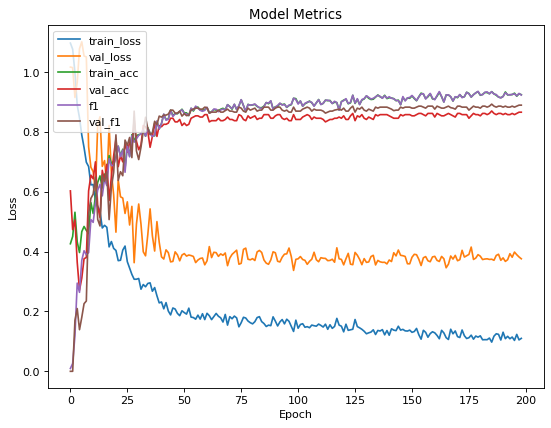

In [19]:
plot_history(history)
plt.show()

## CNN Result Analysis

In [2]:
best_model_path = '.\\Data\\AAPL\\best_model\\model' +'20200414_2153'
get_custom_objects().update({"f1_metric": f1_metric})
model = load_model(best_model_path)

In [23]:
y_test_classes

(250,)

keras evaluate= [0.553562994480133, 0.888, 0.8879206]
Confusion Matrix:
[[  2   0  10]
 [  0   6   7]
 [  1  10 214]]


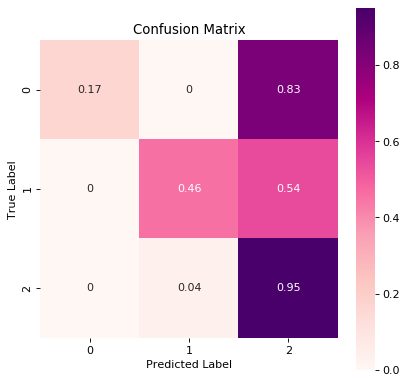

precision of class 0 = 0.17
precision of class 1 = 0.46
precision of class 2 = 0.95
precision avg 0.53 


F1 score (weighted) 0.88
F1 score (macro) 0.54
F1 score (micro) 0.89
cohen's Kappa 0.3191323801186655 



In [20]:
test_res = model.evaluate(x_test, y_test, verbose=0) # loss of test data
print("keras evaluate=", test_res)
pred_classes, y_test_classes =  test_analysis(model, x_test, y_test)
conf_mat = Confusion_Mat(y_test_classes, pred_classes)
cal_f1_scores(y_test_classes, pred_classes)